# Grid Search Intervention

In [1]:
#@title Import libraries
import transformer_lens
import torch, gc, itertools, tqdm, scipy, functools, collections, copy
import pandas as pd
import numpy as np
from pathlib import Path

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['axes.spines.top'] = False

import sys
sys.path.append('/home/jupyter/')
from paraMem.utils import localizing, modelHandlers, dataLoaders, gradient, intervening, evaluation

## Model and Data

In [14]:
model = modelHandlers.load_model(model_type="gpt2-medium", DEVICE="cpu", lr=0.0, weight_decay=0.1)

Loaded pretrained model gpt2-medium into HookedTransformer


In [15]:
train_dl, test_dl = dataLoaders.batched_pile(mem_batch=1, non_mem_batch=10, test_frac=0.0, set_twice=None)
#dl = dataLoaders.batched_pop_seqs(model, mem_batch=5, non_mem_batch=10)
c_toks_NI, k_toks_NI = next(iter(train_dl))

## Run Model and Collect Gradients 

In [16]:
def intervention_grid(model, dl, n_batch:int=1, decode_k:bool=True, I_range:list=[50,100], topK_space:tuple=(0,10,5), lr_space:tuple=(0,3,1), c_types:list=None):
    """
    searching for best intervention setting by iterating over ideal intervention values
    """
    ## set up arrays and loop values
    lr_vals = lr_space #lr_vals = 10 ** torch.flip(torch.linspace(lr_space[0], lr_space[1], steps=lr_space[2]),dims=(0,))
    topK_vals = topK_space #topK_vals = torch.linspace(topK_space[0], topK_space[1], steps=topK_space[2]) 
    print(f"searching over {len(lr_vals)*len(topK_vals)} different topK and lr settings\nlr_vals: {lr_vals}, topK_vals: {topK_vals}")
    ck_em, ck_nll = torch.zeros(len(topK_vals), len(lr_vals)+1,2),torch.zeros(len(topK_vals), len(lr_vals)+1,2)
    
    ## baseline run without any intervention
    model = modelHandlers.load_model(model, lr=0.0)
    metric_fn = functools.partial(gradient.contrast_metric, I_range=I_range, with_mse=True, pool={"c":[-1],"k":[0,-1]}, norm_sets=1.0, only_set=None)
    fwd_bwd_fn = functools.partial(gradient.run_fwd_bwd, optim_step=False, topK=None, grad_norm=None)
    gradient.batched_fwd_bwd(model, dl, metric_fn, fwd_bwd_fn, n_batches=n_batch, c_types=c_types)
    (c_em, k_em), (c_nll, k_nll) = evaluation.batched_model_eval(model, dl=dl, I_range=I_range)
    ck_em[:,0,0], ck_em[:,0,1] = c_em, k_em
    ck_nll[:,0,0], ck_nll[:,0,1] = c_nll, k_nll
    
    if decode_k: ## get predictions on k without intervention
        model = modelHandlers.load_model(model, lr=0.0)
        k_preds_orig, _ = modelHandlers.batch_decode(model, toks_NI=None, dl=train_dl, n_batch=n_batch, new_toks=I_range[1]-I_range[0])
        ck_em[:,0,1] = I_range[1]-I_range[0]
        
    for i, topK_val in tqdm.tqdm(enumerate(topK_vals)):
        for j, lr in enumerate(lr_vals):            
            model = modelHandlers.load_model(model, lr=lr)
            metric_fn = functools.partial(gradient.contrast_metric, I_range=[50,100], with_mse=True, pool={"c":[0],"k":[0]}, norm_sets=1.0, only_set=None)
            fwd_bwd_fn = functools.partial(gradient.run_fwd_bwd, optim_step=True, topK=int(topK_val), grad_norm=None)
            weight_gradients = gradient.batched_fwd_bwd(model, dl, metric_fn, fwd_bwd_fn, n_batches=n_batch, c_types=c_types)
            
            (c_em, k_em), (c_nll, k_nll) = evaluation.batched_model_eval(model, dl=dl, I_range=I_range)
            
            if decode_k: ## compare against decoding on keep set
                k_pred_intervened, _ = modelHandlers.batch_decode(model, toks_NI=None, dl=dl, n_batch=n_batch, new_toks=I_range[1]-I_range[0])
                k_em = evaluation.compute_exact_match(k_pred_intervened, k_preds_orig).mean()

            ck_em[i,j+1,:] = torch.tensor([c_em, k_em])
            ck_nll[i,j+1,:] = torch.tensor([c_nll, k_nll])
                   
    return ck_em, ck_nll, topK_vals, [0.0] + lr_vals


n_batch, I_range, decode_k, topK_space, lr_space, c_types = 1, [50,100], True, [10000,100000], [0.00001, 0.0001], ["W_in","W_out","W_V","W_Q","W_K"]
ck_em, ck_nll, topK_vals, lr_vals = intervention_grid(model, train_dl, n_batch, decode_k, I_range, topK_space=topK_space, lr_space=lr_space, c_types=c_types)

searching over 4 different topK and lr settings
lr_vals: [1e-05, 0.0001], topK_vals: [10000, 100000]
reset model gpt2-medium
Loaded pretrained model gpt2-medium into HookedTransformer


0it [00:00, ?it/s]

contrast_res: -2.7459871768951416, c_nll: 2.7459871768951416, k_nll: 0.0


0it [00:13, ?it/s]

returning ['blocks.0.mlp.W_in', 'blocks.1.mlp.W_in']... of shape: torch.Size([24, 1024, 4096])
returning ['blocks.0.mlp.W_out', 'blocks.1.mlp.W_out']... of shape: torch.Size([24, 4096, 1024])
returning ['blocks.0.attn.W_V', 'blocks.1.attn.W_V']... of shape: torch.Size([24, 16, 1024, 64])
returning ['blocks.0.attn.W_Q', 'blocks.1.attn.W_Q']... of shape: torch.Size([24, 16, 1024, 64])
returning ['blocks.0.attn.W_K', 'blocks.1.attn.W_K']... of shape: torch.Size([24, 16, 1024, 64])


---Greedy EM--- change set: 16.200000762939453, keep set: 0.41999998688697815  [mean over 10 seqs]
---Mean NLL--- change set: 2.216219902038574, keep set: 2.8709001541137695
reset model gpt2-medium
Loaded pretrained model gpt2-medium into HookedTransformer


0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

0it [00:10, ?it/s]
0it [00:00, ?it/s]

reset model gpt2-medium
Loaded pretrained model gpt2-medium into HookedTransformer
added optimizer with lr: 1e-05 and weight_decay: 0.0



0it [00:00, ?it/s]

contrast_res: -2.7459871768951416, c_nll: 2.7459871768951416, k_nll: 0.0
10000 weights in ['W_in', 'W_out', 'W_V', 'W_Q', 'W_K'] with grads > 0.6943116784095764 abs_grad: False
clipped at 0.6943116784095764 with keep_neg: False


0it [00:17, ?it/s]

optimizer step


---Greedy EM--- change set: 16.200000762939453, keep set: 0.4000000059604645  [mean over 10 seqs]
---Mean NLL--- change set: 2.218980073928833, keep set: 2.869880199432373



0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

0it [00:12, ?it/s]


reset model gpt2-medium
Loaded pretrained model gpt2-medium into HookedTransformer
added optimizer with lr: 0.0001 and weight_decay: 0.0



0it [00:00, ?it/s]

contrast_res: -2.7459871768951416, c_nll: 2.7459871768951416, k_nll: 0.0
10000 weights in ['W_in', 'W_out', 'W_V', 'W_Q', 'W_K'] with grads > 0.6943116784095764 abs_grad: False
clipped at 0.6943116784095764 with keep_neg: False


0it [00:21, ?it/s]

optimizer step


---Greedy EM--- change set: 16.200000762939453, keep set: 0.4000000059604645  [mean over 10 seqs]
---Mean NLL--- change set: 2.2523598670959473, keep set: 2.869919776916504



0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

0it [00:13, ?it/s]
1it [01:57, 117.59s/it]

reset model gpt2-medium
Loaded pretrained model gpt2-medium into HookedTransformer
added optimizer with lr: 1e-05 and weight_decay: 0.0



0it [00:00, ?it/s]

contrast_res: -2.7459871768951416, c_nll: 2.7459871768951416, k_nll: 0.0
100000 weights in ['W_in', 'W_out', 'W_V', 'W_Q', 'W_K'] with grads > 0.17589636147022247 abs_grad: False
clipped at 0.17589636147022247 with keep_neg: False


0it [00:22, ?it/s]

optimizer step


---Greedy EM--- change set: 16.200000762939453, keep set: 0.4000000059604645  [mean over 10 seqs]
---Mean NLL--- change set: 2.2204201221466064, keep set: 2.8696999549865723



0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

0it [00:13, ?it/s]


reset model gpt2-medium
Loaded pretrained model gpt2-medium into HookedTransformer
added optimizer with lr: 0.0001 and weight_decay: 0.0



0it [00:00, ?it/s]

contrast_res: -2.7459871768951416, c_nll: 2.7459871768951416, k_nll: 0.0
100000 weights in ['W_in', 'W_out', 'W_V', 'W_Q', 'W_K'] with grads > 0.17589636147022247 abs_grad: False
clipped at 0.17589636147022247 with keep_neg: False
optimizer step


0it [00:23, ?it/s]


---Greedy EM--- change set: 16.200000762939453, keep set: 0.3800000250339508  [mean over 10 seqs]
---Mean NLL--- change set: 2.28413987159729, keep set: 2.872919797897339



0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

0it [00:12, ?it/s]
2it [04:02, 121.14s/it]


In [17]:
def change_keep_metric(ck_em:torch.tensor, ck_nll:torch.tensor):
    """
    computing change metric on em and nll
    """
    c_em, k_em = ck_em[...,0], ck_em[...,1] 
    c_nll, k_nll = ck_nll[...,0], ck_nll[...,1]
    ## dim 0: number of weights, dim 1: noise value

    ## exact match
    c_em_mse = (0 - c_em[:,:])**2
    k_em_mse = (50 - k_em[:,:])**2
    em_mse = c_em_mse + k_em_mse
    
    ## nll match
    k_nll_mse = (k_nll[0,0] - k_nll[:,:])**4 ## any change is bad
    print((c_nll[:,:])**2)
    nll_mse = k_nll_mse - (c_nll[0,0] - c_nll[:,:])**2
    return em_mse, nll_mse
   
#em_mse, nll_mse = change_keep_metric(ck_em, ck_nll)  

In [18]:
#fontsize = 10
#fig, axs = plt.subplots(1, 2, figsize=(5, 2), gridspec_kw={'hspace': 1.2}, constrained_layout=True)
#axs[0].set_title(f"Exact Match Metric", fontsize=fontsize, loc="left")
#axs[1].set_title(f"NLL Metric", fontsize=fontsize, loc="left")

#y = list(map(lambda x: round(x, 5), topK_vals))
#x = list(map(lambda x: round(x, 5), lr_vals))

#metrics = [em_mse, nll_mse]
#sns.heatmap(em_mse,cmap=mpl.colormaps["Blues_r"],ax=axs[0], center=0,xticklabels=x,yticklabels=y,square=False)
#sns.heatmap(nll_mse,cmap=mpl.colormaps["Blues_r"],ax=axs[1], center=0,xticklabels=x,yticklabels=y,square=False)

#axs[0].set_ylabel(f"topK weights", fontsize=fontsize)
#axs[0].set_xlabel(f"lr", fontsize=fontsize)
#axs[1].set_xlabel(f"lr", fontsize=fontsize)


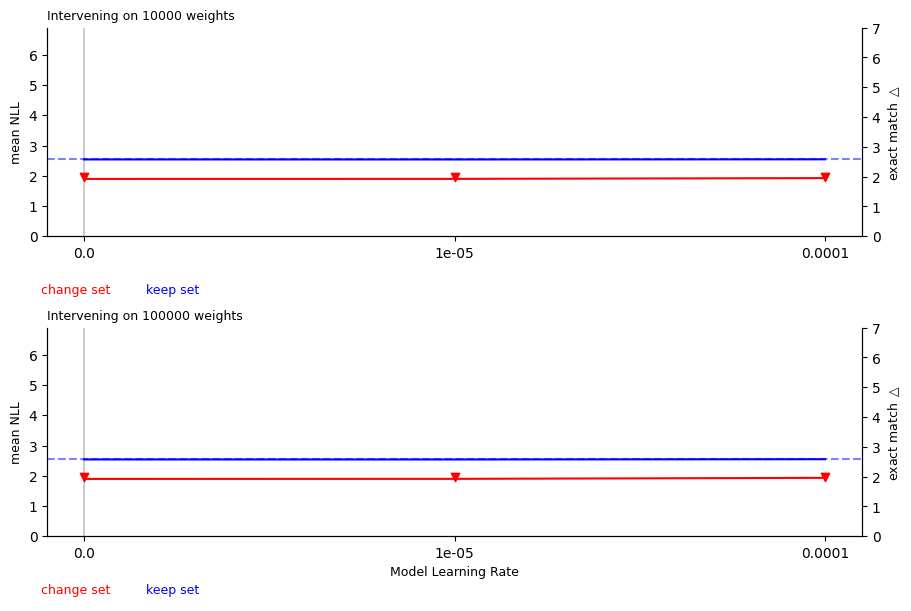

In [19]:
fontsize = 9
fig, axs = plt.subplots(ck_em.shape[0], 1, figsize=(9, 6), gridspec_kw={'wspace': 0.6}, constrained_layout=True)

for i, ax in enumerate(axs):
    x = np.arange(0,len(lr_vals),1)
    
    c_nll, = ax.plot(x, ck_nll[i,:,0].numpy(), c="red", label="change set")
    k_nll, = ax.plot(x, ck_nll[i,:,1].numpy(), c="blue", label="keep set")
    ax.axhline(y=ck_nll[i,0,1], color='r', linestyle='--', c="blue", alpha=0.5)

    ax2 = ax.twinx()
    c_em = ax2.scatter(x, ck_em[i,:,0].numpy(), c="red", marker="v", label="change set em")
    k_em = ax2.scatter(x, ck_em[i,:,1].numpy(), c="blue", marker="^", label="keep set em")
    ax.axvline(x=0, color='r', linestyle='-', c="black", alpha=0.2)

    #ax.set_xscale('log')
    #ax.set_xscale('function', functions=(functools.partial(np.power, 10.0), np.log10))

    #plot_summary = f"Intervening on top {model.cfg.intervention['n_weights']} max gradient weights {model.cfg.intervention['c_types']}"
    #plot_summary = f"Intervening on top {model.cfg.intervention['n_weights']} max gradient weights {model.cfg.intervention['c_types']} in layers: {', '.join((str(l) for l in model.cfg.intervention['layers']))}"
    ax.set_title(f"Intervening on {topK_vals[i]} weights", fontsize=fontsize, loc="left")
    if i == ck_em.shape[0]-1:
        ax.set_xlabel('Model Learning Rate', fontsize=fontsize)
    #ax.set_xticklabels(lr_vals.tolist())
    ax.set_xticks(x)
    ax.set_xticklabels(lr_vals)
    
    ax.set_ylabel(r'mean NLL', fontsize=fontsize) #\searrow
    ax2.set_ylabel(r'exact match $\triangle$', fontsize=fontsize) #\bullet
    ax.set_ylim(0,ck_nll[0,0,0]+5)
    ax2.set_ylim(0,ck_em[0,0,0]+5)
    legend = ax.legend(handles=[c_nll, k_nll], frameon=False, bbox_to_anchor=(0.2, -0.17), ncol=2, prop={'size': fontsize}, handlelength=0)
    for text, color in zip(legend.get_texts(), ["red", "blue"]):
        text.set_color(color) 
    #ax.savefig("...", dpi=200, bbox_inches='tight')